# Install Dependencies

In [260]:
import tensorflow as tf
import os
import tqdm
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

# INCEPTIONV3 Model

## Model Building

### Setup the pre-trained model

In [366]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights into a variable
local_weights_file = 'pre_trained_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model
# Set the input shape and remove the dense layers
pre_trained_model = InceptionV3(input_shape = (299, 299, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False
#pre_trained_model.summary()

In [367]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 17, 17, 768)


### Add our layer into it

There are 98 classes in our dataset, so we will make the output layer having 98 classes and use the softmax function.

In [368]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

x = Dense(128, activation = 'relu')(x) 
x = Dense(64, activation = 'relu')(x) 
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (98, activation='softmax')(x)

# Append the dense network to the base model
model_incV3 = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
#model_incV3.summary()

### Compile the model

We will compile the model by trying different optimizer.

#### RMSprop

In [354]:
from tensorflow.keras.optimizers import RMSprop
# Set the training parameters
model_incV3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Adam

In [369]:
from tensorflow.keras.optimizers import Adam
# Set the training parameters
model_incV3.compile(optimizer=Adam(learning_rate=0.001),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Model summary

In [ ]:
model_incV3.summary()

## Preparing the dataset

### Specify data directory

In [370]:
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# #If mounting from google drive:
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/dataaa'

### Create ImageDataGenerator

We want to load our data using ImageDataGenerator to be able to automatically apply data augmentation on the data. On top of that, we also want to rescale the data to be in range of 0–1.

But, we are not doing any augmentation on the test data, so we create 2 datagen object for each train and test where the train has data augmentation and the test doesn't.

In [371]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
                            rescale = 1./255.,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True
)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

### Create validation data generator

In [372]:
# Generate augmented data batches from a directory
val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 2356 images belonging to 98 classes.


### Create training data generator

In [373]:
# Generate augmented data batches from a directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 9194 images belonging to 98 classes.


### Take the class label

In [359]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Babi kecap
1 : Bacon
2 : Bacon and Egg
3 : Bakso
4 : Balado udang telur terasi
5 : Bolu keju
6 : Bread
7 : Brownies
8 : Burger
9 : Cappuccino
10 : Chai latte
11 : Cheese and bacon potato skins
12 : Cheese and broccoli casserole
13 : Cheese and garlic bread
14 : Cheese and ham croissant
15 : Cheese and herb scones
16 : Cheese and mushroom risotto
17 : Cheese and olive stuffed bread
18 : Cheese and onion pie
19 : Cheese and pesto panini
20 : Cheese and spinach stuffed chicken breast
21 : Cheese and tomato tart
22 : Cheese breadsticks
23 : Cheese calzone
24 : Cheese fries
25 : Cheese omelette
26 : Cheese soufflé
27 : Cheesecake
28 : Chia pudding
29 : Choco Lava Cake
30 : Cookie
31 : Cornbread
32 : Crepes
33 : Dadar Gulung Keju
34 : Egg Benedict
35 : Egg Noodle
36 : Fish and chips
37 : French Omelette
38 : Fried Rice
39 : Grilled cheese
40 : Gurame bakar
41 : Gurame goreng
42 : Ikan cakalang rica-rica
43 : Ikan

## Model Training

### (Bad) Testing rmsprop optimizer with 50% dropout

In [360]:
model_incV3_rmsprop_50dropout = model_incV3

In [363]:
# Train the model.
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history = model_incV3_rmsprop_50dropout.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = STEP_SIZE_TRAIN,
            epochs = 10,
            validation_steps = STEP_SIZE_VALID)

Epoch 1/10


2023-06-15 03:19:29.374368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - 266s 927ms/step - loss: 3.4070 - accuracy: 0.1327 - val_loss: 3.2311 - val_accuracy: 0.1605
Epoch 2/10
287/287 [==============================] - 262s 914ms/step - loss: 3.3119 - accuracy: 0.1458 - val_loss: 3.2464 - val_accuracy: 0.1644
Epoch 3/10
287/287 [==============================] - 262s 912ms/step - loss: 3.2241 - accuracy: 0.1615 - val_loss: 3.0899 - val_accuracy: 0.1708
Epoch 4/10
287/287 [==============================] - 262s 911ms/step - loss: 3.1777 - accuracy: 0.1628 - val_loss: 3.2163 - val_accuracy: 0.1747
Epoch 5/10
287/287 [==============================] - 265s 924ms/step - loss: 3.0999 - accuracy: 0.1767 - val_loss: 3.0672 - val_accuracy: 0.2025
Epoch 6/10
287/287 [==============================] - 261s 910ms/step - loss: 3.0684 - accuracy: 0.1765 - val_loss: 3.0311 - val_accuracy: 0.1956
Epoch 7/10
287/287 [==============================] - 262s 913ms/step - loss: 3.0376 - accuracy: 0.1846 - val_loss: 2.9268 - val_accura

### (Bad) Testing adam optimizer with 20% dropout with 2 dense layer of 128 and 64

In [374]:
model_incV3_adam_20dropout = model_incV3

In [375]:
# Train the model.

history_adam = model_incV3_adam_20dropout.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = STEP_SIZE_TRAIN,
            epochs = 5,
            validation_steps = STEP_SIZE_VALID)

Epoch 1/5


2023-06-15 04:25:45.635982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - ETA: 0s - loss: 4.6328 - accuracy: 0.0226

2023-06-15 04:29:50.747076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - 272s 935ms/step - loss: 4.6328 - accuracy: 0.0226 - val_loss: 4.5260 - val_accuracy: 0.0342
Epoch 2/5
287/287 [==============================] - 269s 936ms/step - loss: 4.4657 - accuracy: 0.0350 - val_loss: 4.3367 - val_accuracy: 0.0428
Epoch 3/5
287/287 [==============================] - 269s 937ms/step - loss: 4.3077 - accuracy: 0.0408 - val_loss: 4.2068 - val_accuracy: 0.0505
Epoch 4/5
287/287 [==============================] - 262s 913ms/step - loss: 4.1966 - accuracy: 0.0472 - val_loss: 4.1276 - val_accuracy: 0.0514
Epoch 5/5
287/287 [==============================] - 263s 917ms/step - loss: 4.1230 - accuracy: 0.0489 - val_loss: 4.0731 - val_accuracy: 0.0544


# Another InceptionV3

## Model Building

### Setup pre-trained model

In [264]:
base_model = InceptionV3(weights='imagenet', 
                        include_top=False, 
                        input_shape=(299, 299, 3))
base_model.trainable = False

## Add our layer

In [265]:
import keras
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
# let's add a fully-connected layer
x = layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
# and a sofymax/logistic layer -- we have 6 classes
predictions = Dense(98, activation='softmax')(x)

In [266]:
model2 = Model(base_model.input, predictions)

## Compile the model

In [269]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

### InceptionV3 version 2 model

#### (decent) First train

In [128]:
# Train the model.

history = model2.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 40,
            validation_steps = 50)

Epoch 1/40


2023-06-14 07:21:55.602922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 5.2993 - categorical_accuracy: 0.1744

2023-06-14 07:22:41.081852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 54s 492ms/step - loss: 5.2993 - categorical_accuracy: 0.1744 - val_loss: 3.5507 - val_categorical_accuracy: 0.3237
Epoch 2/40
100/100 [==============================] - 51s 516ms/step - loss: 3.3167 - categorical_accuracy: 0.3406 - val_loss: 3.1758 - val_categorical_accuracy: 0.3963
Epoch 3/40
100/100 [==============================] - 49s 490ms/step - loss: 3.2756 - categorical_accuracy: 0.3821 - val_loss: 3.1388 - val_categorical_accuracy: 0.4288
Epoch 4/40
100/100 [==============================] - 48s 482ms/step - loss: 3.0004 - categorical_accuracy: 0.4331 - val_loss: 2.6498 - val_categorical_accuracy: 0.4812
Epoch 5/40
100/100 [==============================] - 48s 485ms/step - loss: 3.0150 - categorical_accuracy: 0.4586 - val_loss: 3.1203 - val_categorical_accuracy: 0.4512
Epoch 6/40
100/100 [==============================] - 47s 473ms/step - loss: 2.9254 - categorical_accuracy: 0.4675 - val_loss: 2.9530 - val_categorical_accuracy: 0.48

In [129]:
model2.save('models/inceptionV3_5dropout_2_5lr.h5')

#### (decent) Second train

In [130]:
# Train the model.

history = model2.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50)

Epoch 1/100


2023-06-14 07:55:50.052567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 2.1376 - categorical_accuracy: 0.6594

2023-06-14 07:56:29.465392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 48s 476ms/step - loss: 2.1376 - categorical_accuracy: 0.6594 - val_loss: 3.5201 - val_categorical_accuracy: 0.5612
Epoch 2/100
100/100 [==============================] - 50s 495ms/step - loss: 2.0588 - categorical_accuracy: 0.6606 - val_loss: 3.0686 - val_categorical_accuracy: 0.6075
Epoch 3/100
100/100 [==============================] - 48s 478ms/step - loss: 1.9611 - categorical_accuracy: 0.6637 - val_loss: 2.9669 - val_categorical_accuracy: 0.5962
Epoch 4/100
100/100 [==============================] - 48s 483ms/step - loss: 2.0422 - categorical_accuracy: 0.6644 - val_loss: 3.1096 - val_categorical_accuracy: 0.5850
Epoch 5/100
100/100 [==============================] - 48s 481ms/step - loss: 2.3502 - categorical_accuracy: 0.6488 - val_loss: 3.6129 - val_categorical_accuracy: 0.5738
Epoch 6/100
100/100 [==============================] - 48s 482ms/step - loss: 1.9673 - categorical_accuracy: 0.6725 - val_loss: 3.1916 - val_categorical_accuracy:

In [131]:
model2.save('models/inceptionV3_5dropout_2_5lr_2.h5')

#### (decent) Third train

In [132]:
# Train the model.

history = model2.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 30,
            validation_steps = 50)

Epoch 1/30


2023-06-14 09:16:56.252492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 1.4997 - categorical_accuracy: 0.7744

2023-06-14 09:17:36.646878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 48s 479ms/step - loss: 1.4997 - categorical_accuracy: 0.7744 - val_loss: 3.8499 - val_categorical_accuracy: 0.6538
Epoch 2/30
100/100 [==============================] - 48s 478ms/step - loss: 1.5448 - categorical_accuracy: 0.7769 - val_loss: 3.9667 - val_categorical_accuracy: 0.6187
Epoch 3/30
100/100 [==============================] - 48s 477ms/step - loss: 1.5682 - categorical_accuracy: 0.7719 - val_loss: 4.3753 - val_categorical_accuracy: 0.6150
Epoch 4/30
100/100 [==============================] - 48s 476ms/step - loss: 1.6032 - categorical_accuracy: 0.7744 - val_loss: 3.6454 - val_categorical_accuracy: 0.6513
Epoch 5/30
100/100 [==============================] - 49s 490ms/step - loss: 1.5052 - categorical_accuracy: 0.7750 - val_loss: 3.8087 - val_categorical_accuracy: 0.6475
Epoch 6/30
100/100 [==============================] - 46s 464ms/step - loss: 1.6361 - categorical_accuracy: 0.7631 - val_loss: 3.4016 - val_categorical_accuracy: 0.65

In [133]:
model2.save('models/inceptionV3_5dropout_2_5lr_3.h5')

#### (good) Fourth train

In [134]:
# Train the model.

history = model2.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 30,
            validation_steps = 50)

Epoch 1/30


2023-06-14 09:46:44.205675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 1.8823 - categorical_accuracy: 0.7569

2023-06-14 09:47:24.276198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 48s 477ms/step - loss: 1.8823 - categorical_accuracy: 0.7569 - val_loss: 3.9814 - val_categorical_accuracy: 0.6375
Epoch 2/30
100/100 [==============================] - 48s 478ms/step - loss: 1.8282 - categorical_accuracy: 0.7806 - val_loss: 3.7799 - val_categorical_accuracy: 0.6425
Epoch 3/30
100/100 [==============================] - 47s 475ms/step - loss: 1.5918 - categorical_accuracy: 0.7656 - val_loss: 4.2075 - val_categorical_accuracy: 0.6275
Epoch 4/30
100/100 [==============================] - 48s 477ms/step - loss: 1.5122 - categorical_accuracy: 0.7887 - val_loss: 3.7717 - val_categorical_accuracy: 0.6375
Epoch 5/30
100/100 [==============================] - 48s 483ms/step - loss: 1.5671 - categorical_accuracy: 0.7831 - val_loss: 3.7037 - val_categorical_accuracy: 0.6488
Epoch 6/30
100/100 [==============================] - 49s 489ms/step - loss: 1.3538 - categorical_accuracy: 0.7956 - val_loss: 3.9605 - val_categorical_accuracy: 0.65

In [135]:
model2.save('models/inceptionV3_5dropout_2_5lr_4.h5')

In [136]:
# Train the model.

history = model2.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 30,
            validation_steps = 50)

Epoch 1/30


2023-06-14 10:15:49.067983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 1.6410 - categorical_accuracy: 0.7825

2023-06-14 10:16:29.935170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 48s 484ms/step - loss: 1.6410 - categorical_accuracy: 0.7825 - val_loss: 4.6079 - val_categorical_accuracy: 0.6250
Epoch 2/30
100/100 [==============================] - 48s 479ms/step - loss: 1.6367 - categorical_accuracy: 0.7911 - val_loss: 3.9669 - val_categorical_accuracy: 0.6625
Epoch 3/30
100/100 [==============================] - 47s 474ms/step - loss: 1.5617 - categorical_accuracy: 0.7869 - val_loss: 4.2502 - val_categorical_accuracy: 0.6500
Epoch 4/30
100/100 [==============================] - 48s 476ms/step - loss: 1.5174 - categorical_accuracy: 0.7937 - val_loss: 4.0780 - val_categorical_accuracy: 0.6737
Epoch 5/30
100/100 [==============================] - 48s 481ms/step - loss: 1.5236 - categorical_accuracy: 0.7867 - val_loss: 4.4930 - val_categorical_accuracy: 0.6488
Epoch 6/30
100/100 [==============================] - 48s 479ms/step - loss: 1.4059 - categorical_accuracy: 0.8019 - val_loss: 4.2167 - val_categorical_accuracy: 0.64

In [280]:
#### (best) Fifth train

In [270]:
# Train the model.
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history_model2 = model2.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = STEP_SIZE_TRAIN,
            epochs = 5,
            validation_steps = STEP_SIZE_VALID)

Epoch 1/5


2023-06-15 00:58:38.152843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - 304s 1s/step - loss: 0.7017 - categorical_accuracy: 0.8633 - val_loss: 2.9302 - val_categorical_accuracy: 0.7055
Epoch 2/5
287/287 [==============================] - 300s 1s/step - loss: 0.7508 - categorical_accuracy: 0.8576 - val_loss: 2.7937 - val_categorical_accuracy: 0.6973
Epoch 3/5
287/287 [==============================] - 295s 1s/step - loss: 0.7236 - categorical_accuracy: 0.8593 - val_loss: 2.9076 - val_categorical_accuracy: 0.6935
Epoch 4/5
287/287 [==============================] - 297s 1s/step - loss: 0.6796 - categorical_accuracy: 0.8667 - val_loss: 3.0379 - val_categorical_accuracy: 0.6836
Epoch 5/5
287/287 [==============================] - 295s 1s/step - loss: 0.7385 - categorical_accuracy: 0.8602 - val_loss: 3.1392 - val_categorical_accuracy: 0.6973


In [281]:
model2.save('models/inceptionV3_best.h5')

## Evaluate

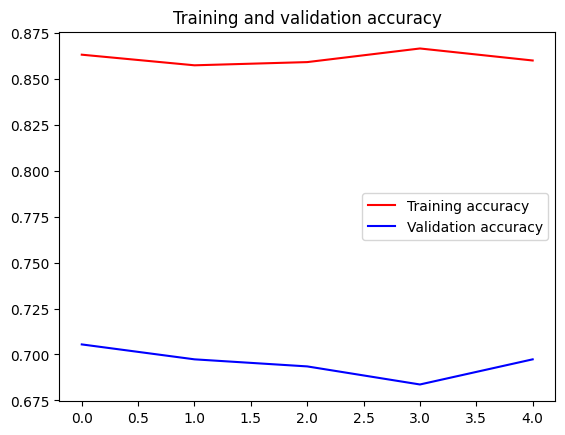

<Figure size 640x480 with 0 Axes>

In [272]:
import matplotlib.pyplot as plt
acc = history_model2.history['categorical_accuracy']
val_acc = history_model2.history['val_categorical_accuracy']
loss = history_model2.history['loss']
val_loss = history_model2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Test with some image

1/1 [==============================] - 0s 28ms/step


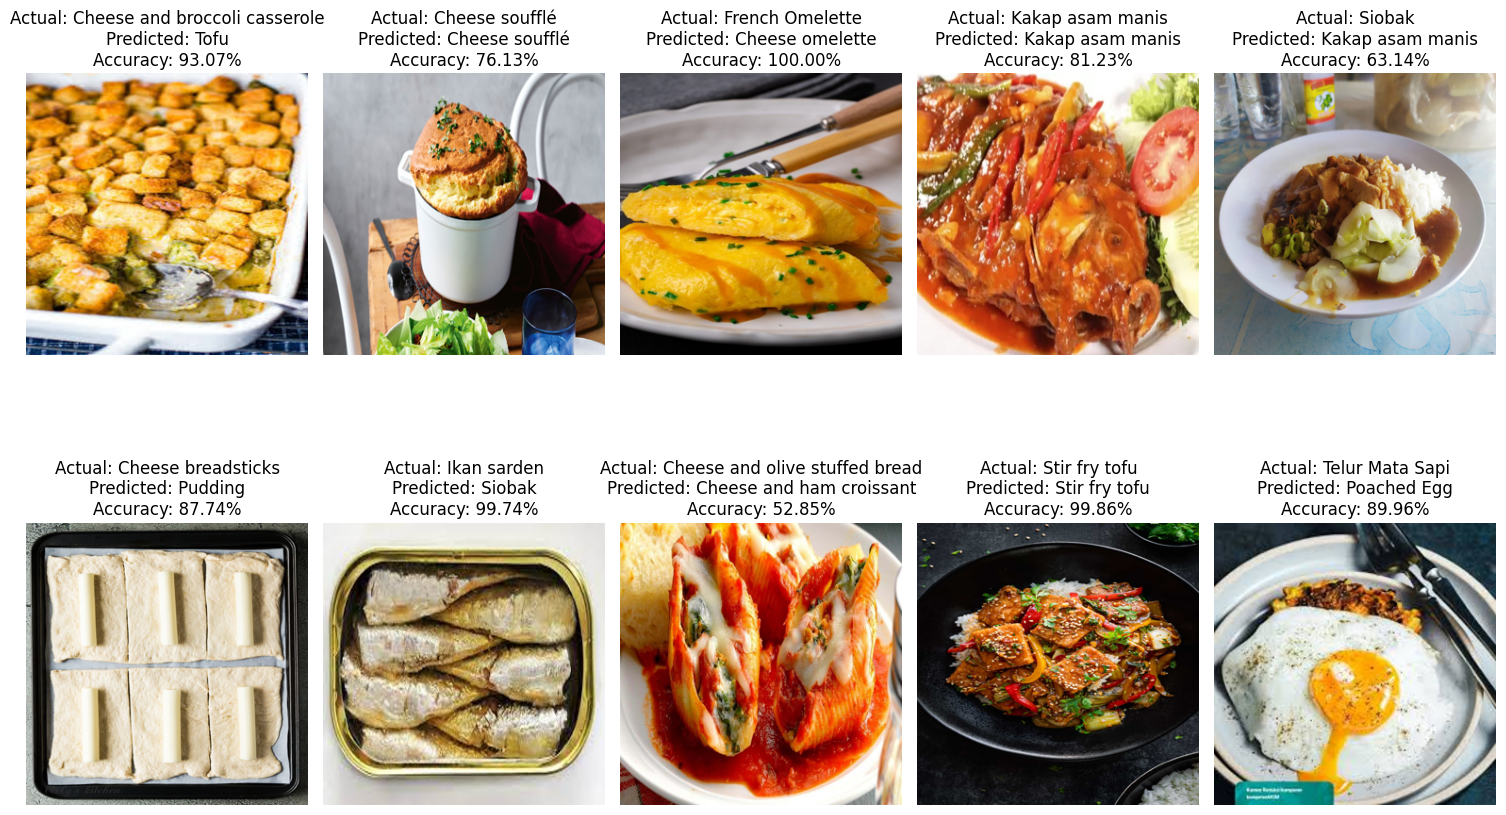

In [312]:
from PIL import Image
import random

# Path to the test directory
test_dir = 'data/test'

# Get a list of all image file paths in the test directory
image_paths = []
for root, _, files in os.walk(test_dir):
    image_paths.extend([os.path.join(root, file) for file in files])

# Select 10 random image paths
random_image_paths = random.sample(image_paths, 10)

# Set the figure size based on the desired layout
plt.figure(figsize=(15, 10))

# Process and predict each selected image
for i, image_path in enumerate(random_image_paths):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((299, 299))  # Adjust to the input dimensions of your model
    image = np.array(image) / 255.0  # Normalize the pixel values (if necessary)
    image = np.expand_dims(image, axis=0)  # Expand dimensions to create a batch of size 1

    # Perform the prediction
    prediction = model2.predict(image)

    # Interpret the prediction
    predicted_class = np.argmax(prediction)
    predicted_prob = np.max(prediction)
    predicted_label = labels[predicted_class]

    # Extract the actual label from the image path
    actual_label = os.path.basename(os.path.dirname(image_path))

    # Calculate the predicted accuracy
    predicted_accuracy = predicted_prob * 100

    # Plot the image and prediction results
    plt.subplot(2, 5, i + 1)
    plt.imshow(image[0])
    plt.axis('off')
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}\nAccuracy: {predicted_accuracy:.2f}%')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 31ms/step


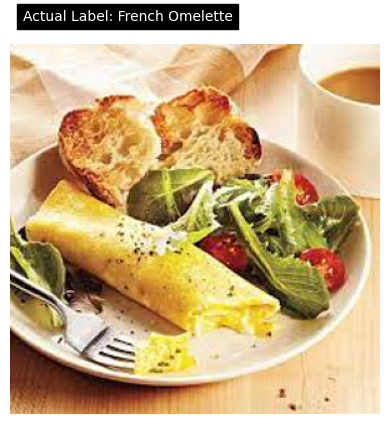

Top 10 Predictions:
French Omelette: 0.9999518394470215
Cheese calzone: 2.946516360680107e-05
Spageti udang: 9.25566018850077e-06
Kakap asam manis: 8.020531822694466e-06
Cheese omelette: 7.014053835519007e-07
Nasi babi guling: 5.822490720674978e-07
Cheese and garlic bread: 5.868892571925244e-08
Dadar Gulung Keju: 3.133157733259395e-08
Scrambled Egg: 9.962811908792446e-09
Siobak: 9.492882924178048e-09


In [335]:
# Path to the test directory
test_dir = 'data/test'

# Get a list of all image file paths in the test directory
image_paths = []
for root, _, files in os.walk(test_dir):
    image_paths.extend([os.path.join(root, file) for file in files])

# Select a random image path
random_image_path = random.choice(image_paths)

# Load and preprocess the image
image = Image.open(random_image_path)
image = image.resize((299, 299))  # Adjust to the input dimensions of your model
image = np.array(image) / 255.0  # Normalize the pixel values (if necessary)
image = np.expand_dims(image, axis=0)  # Expand dimensions to create a batch of size 1

# Perform the prediction
predictions = model2.predict(image)

# Get the top 10 predicted classes and probabilities
top_classes = np.argsort(-predictions)[0][:10]
top_probs = predictions[0][top_classes]

# Map the predicted class indices to class labels using the `labels` dictionary
top_labels = [labels[class_idx] for class_idx in top_classes]

# Get the actual label from the image path
actual_label = os.path.basename(os.path.dirname(random_image_path))
# Display the image
plt.imshow(image[0])
plt.axis('off')
plt.text(10, -20, f"Actual Label: {actual_label}", color='white', backgroundcolor='black')

plt.show()

# Print the top 10 predicted classes with probabilities
print("Top 10 Predictions:")
for label, prob in zip(top_labels, top_probs):
    print(f"{label}: {prob}")

# InceptionResNetV2

## Model Building

### Setup the pre-trained model

In [246]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

### Add our layer to it

We will add 3 dense layer and also do a 20% dropout.

In [247]:
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
model_IRNV2 = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(98, activation='softmax')
    ])

### Compile the model

In [248]:
model_IRNV2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


### Model summary

In [249]:
model_IRNV2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_1723 (B  (None, 9, 9, 1536)       10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_19  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_38 (Dense)            (None, 512)               786944    
                                                                 
 dense_39 (Dense)            (None, 256)               131328    
                                                      

### Make an early stopping callback

In [250]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                        min_delta=0.001,
                                        restore_best_weights=True)
# early stopping call back


## Preparing the dataset

In [167]:
import numpy as np
from matplotlib import pyplot as plt

In [241]:
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# #If mounting from google drive:
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/dataaa'

We want to load our data using ImageDataGenerator to be able to automatically apply data augmentation on the data. On top of that, we also want to rescale the data to be in range of 0–1.

But, we are not doing any augmentation on the test data, so we create 2 datagen object for each train and test where the train has data augmentation and the test doesn't.

In [243]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
                            rescale = 1./255.,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True
)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

### Create validation data generator

In [244]:
# Generate augmented data batches from a directory
val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(331, 331),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 2356 images belonging to 98 classes.


### Create training data generator

In [245]:
# Generate augmented data batches from a directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(331, 331),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 9194 images belonging to 98 classes.


## Model Training

### First train with 5 epoch

In [256]:
# fit model
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history_inceptionResNetV2 = model_IRNV2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,
                    callbacks=[early])

Epoch 1/5


2023-06-14 13:24:07.469641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - ETA: 0s - loss: 1.5453 - accuracy: 0.5631

2023-06-14 13:28:51.416295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - 316s 1s/step - loss: 1.5453 - accuracy: 0.5631 - val_loss: 1.4265 - val_accuracy: 0.6006
Epoch 2/5
287/287 [==============================] - 313s 1s/step - loss: 1.3051 - accuracy: 0.6158 - val_loss: 1.3553 - val_accuracy: 0.6160
Epoch 3/5
287/287 [==============================] - 311s 1s/step - loss: 1.1612 - accuracy: 0.6538 - val_loss: 1.2947 - val_accuracy: 0.6426
Epoch 4/5
287/287 [==============================] - 313s 1s/step - loss: 1.0227 - accuracy: 0.6928 - val_loss: 1.2889 - val_accuracy: 0.6490
Epoch 5/5
287/287 [==============================] - 308s 1s/step - loss: 0.9460 - accuracy: 0.7109 - val_loss: 1.2593 - val_accuracy: 0.6515


#### Save the model

In [257]:
model2.save('models/inceptionResNetV2_1.h5')

### Second train with 10 epoch

In [258]:
history_inceptionResNetV2 = model_IRNV2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[early])

Epoch 1/10


2023-06-14 13:50:24.178093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - ETA: 0s - loss: 0.8607 - accuracy: 0.7306

2023-06-14 13:55:03.562865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - 311s 1s/step - loss: 0.8607 - accuracy: 0.7306 - val_loss: 1.3162 - val_accuracy: 0.6494
Epoch 2/10
287/287 [==============================] - 308s 1s/step - loss: 0.8193 - accuracy: 0.7501 - val_loss: 1.2101 - val_accuracy: 0.6755
Epoch 3/10
287/287 [==============================] - 316s 1s/step - loss: 0.7559 - accuracy: 0.7669 - val_loss: 1.2337 - val_accuracy: 0.6759
Epoch 4/10
287/287 [==============================] - 309s 1s/step - loss: 0.6984 - accuracy: 0.7813 - val_loss: 1.2235 - val_accuracy: 0.6734
Epoch 5/10
287/287 [==============================] - 318s 1s/step - loss: 0.6920 - accuracy: 0.7813 - val_loss: 1.2641 - val_accuracy: 0.6725
Epoch 6/10
287/287 [==============================] - 311s 1s/step - loss: 0.6429 - accuracy: 0.7959 - val_loss: 1.2063 - val_accuracy: 0.6828
Epoch 7/10
287/287 [==============================] - 316s 1s/step - loss: 0.6143 - accuracy: 0.8006 - val_loss: 1.2292 - val_accuracy: 0.6815
Epoch 8/10

#### Save the model

In [259]:
model2.save('models/inceptionResNetV2_2.h5')

## Evaluate

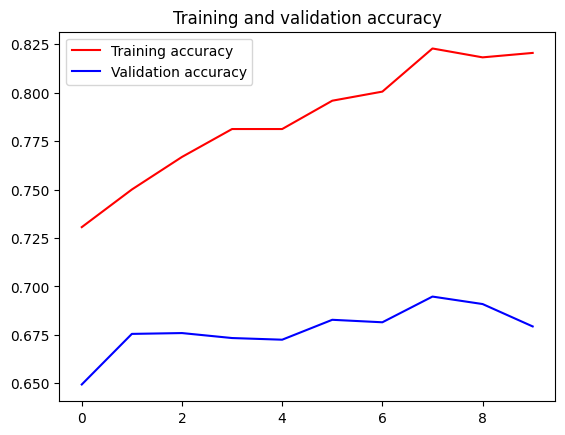

<Figure size 640x480 with 0 Axes>

In [300]:
import matplotlib.pyplot as plt
acc = history_inceptionResNetV2.history['accuracy']
val_acc = history_inceptionResNetV2.history['val_accuracy']
loss = history_inceptionResNetV2.history['loss']
val_loss = history_inceptionResNetV2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [301]:
history_inceptionResNetV2_2 = model_IRNV2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2,
                    callbacks=[early])

Epoch 1/2


2023-06-15 02:10:12.563455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8296

2023-06-15 02:14:57.559684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


287/287 [==============================] - 318s 1s/step - loss: 0.5239 - accuracy: 0.8296 - val_loss: 1.3539 - val_accuracy: 0.6682
Epoch 2/2
287/287 [==============================] - 320s 1s/step - loss: 0.5125 - accuracy: 0.8365 - val_loss: 1.2908 - val_accuracy: 0.6986


1/1 [==============================] - 0s 38ms/step


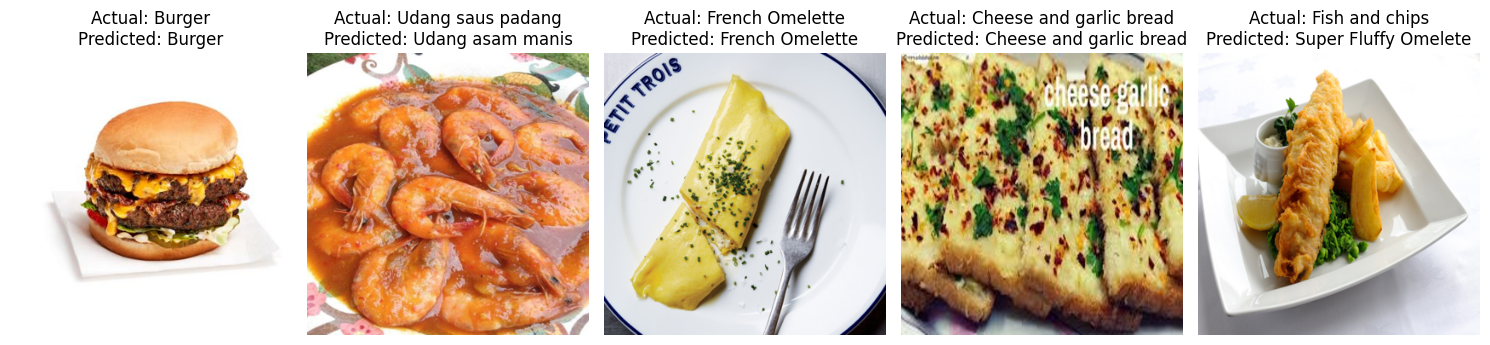

In [344]:
from PIL import Image
import random

# Path to the test directory
test_dir = 'data/test'

# Get a list of all image file paths and their corresponding folder names in the test directory
image_paths = []
folder_names = []
for root, folders, files in os.walk(test_dir):
    for file in files:
        image_paths.append(os.path.join(root, file))
        folder_names.append(os.path.basename(root))

# Select 5 random indices
random_indices = random.sample(range(len(image_paths)), 5)

# Set the figure size based on the desired layout
plt.figure(figsize=(15, 5))

# Process and predict each selected image
for i, idx in enumerate(random_indices):
    image_path = image_paths[idx]
    folder_name = folder_names[idx]

    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((331, 331))  # Adjust to the input dimensions of your model
    image = np.array(image) / 255.0  # Normalize the pixel values (if necessary)
    image = np.expand_dims(image, axis=0)  # Expand dimensions to create a batch of size 1

    # Perform the prediction
    prediction = model_IRNV2.predict(image)

    # Interpret the prediction
    predicted_class = np.argmax(prediction)
    predicted_prob = np.max(prediction)
    predicted_label = labels[predicted_class]

    # Plot the image and prediction results
    plt.subplot(1, 5, i + 1)
    plt.imshow(image[0])
    plt.axis('off')
    plt.title(f'Actual: {folder_name}\nPredicted: {predicted_label}')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 39ms/step


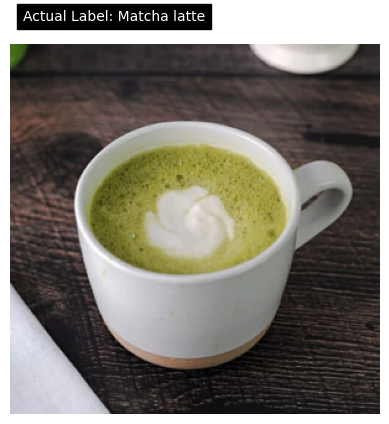

Top 10 Predictions:
Latte: 0.48415884375572205
Cappuccino: 0.38824090361595154
Matcha latte: 0.0987507775425911
Chai latte: 0.024294942617416382
Tiramisu: 0.001392754609696567
Smoothie: 0.0008232045802287757
Milkshake: 0.00032502622343599796
Cheese soufflé: 0.00030592732946388423
Milk: 0.00028919955366291106
Cheesecake: 0.00026355887530371547


In [350]:
# Path to the test directory
test_dir = 'data/test'

# Get a list of all image file paths in the test directory
image_paths = []
for root, _, files in os.walk(test_dir):
    image_paths.extend([os.path.join(root, file) for file in files])

# Select a random image path
random_image_path = random.choice(image_paths)

# Load and preprocess the image
image = Image.open(random_image_path)
image = image.resize((299, 299))  # Adjust to the input dimensions of your model
image = np.array(image) / 255.0  # Normalize the pixel values (if necessary)
image = np.expand_dims(image, axis=0)  # Expand dimensions to create a batch of size 1

# Perform the prediction
predictions = model_IRNV2.predict(image)

# Get the top 10 predicted classes and probabilities
top_classes = np.argsort(-predictions)[0][:10]
top_probs = predictions[0][top_classes]

# Map the predicted class indices to class labels using the `labels` dictionary
top_labels = [labels[class_idx] for class_idx in top_classes]

# Get the actual label from the image path
actual_label = os.path.basename(os.path.dirname(random_image_path))
# Display the image
plt.imshow(image[0])
plt.axis('off')
plt.text(10, -20, f"Actual Label: {actual_label}", color='white', backgroundcolor='black')

plt.show()

# Print the top 10 predicted classes with probabilities
print("Top 10 Predictions:")
for label, prob in zip(top_labels, top_probs):
    print(f"{label}: {prob}")